<a href="https://colab.research.google.com/github/prabhudc/DQ/blob/master/Linear_Regression_Predicting_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting House Sale Prices

## Objective

The objective of this exercise is to build and effective model to predict prices of houses in Ames, Iowa, United States. The data is a well known publif domain dataset surveyed from this region. 

Here we will walk through the steps to model effectively a Linear Regression Model with all the needed bells and whistles to get the model working.

In [1]:
# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preperation

In [2]:
data = pd.read_csv('/content/drive/My Drive/DataScience/files/AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

### Function : Transform Features
Define a reusable function to tranform features.

In [3]:
def transform_features(df, null_drop_pct=.05, corr_to_target=.45, stddev_thresh = 500, unique_count_thresh = 20 ):  
  df_local = df.copy()
  # Determine columns to be dropped
  columns_to_be_dropped = ['Order', # Just a numerical index
                           'PID',   # Process ID
                           'Garage Yr Blt',
                           'Yr Sold',
                           'Mo Sold'
  ]
  df_local.drop(columns=columns_to_be_dropped,inplace=True)
  print('Dropped following features as they are not meaningful predictive features',columns_to_be_dropped)
  # Determine columns for which less than 5% of the records have null values
  less_than_5perc_nulls = df_local.columns[(df_local.isnull().sum() > 0 ) & (df_local.isnull().sum() < (df_local.shape[0]*null_drop_pct)) ]
  # For all such columns, update the nulls with the most frequent value in that column
  for col in less_than_5perc_nulls:
    # Get the most frequent column
    most_freqent_val = df_local[col].value_counts().index[0]
    # Set the nulls to the most frequent valye
    df_local.loc[df_local[col].isnull(),col] = most_freqent_val
  

  df_local['years_until_remod'] = df_local['Year Remod/Add'] - df_local['Year Built']  
  df_local.drop(columns=['Year Remod/Add','Year Built'],inplace=True)
  print('Dropped following features as they are not meaningful predictive features',['Year Remod/Add','Year Built'])

  # Drop columns that have a weak correlation to the target
  # Select all numeric features
  df_temp_numeric = df_local.select_dtypes(include=['int64','float64'])
  # Calculate the correlation matrix
  corr_mtrx = np.abs(df_temp_numeric.corr())
  weak_ftrs_to_drop = corr_mtrx[corr_mtrx['SalePrice'] < corr_to_target].index
  print('Dropped following features as they have a weak correlation with SalePrice',weak_ftrs_to_drop)
  df_local.drop(columns=weak_ftrs_to_drop,inplace=True)

  # Drop columns that have a strong correlation to the each other
  # Select all numeric features
  strong_ftrs_to_drop = ['Garage Cars','1st Flr SF','TotRms AbvGrd','Full Bath']
  df_local.drop(columns=strong_ftrs_to_drop,inplace=True)

  # Drop non-numeric columns that have significant nulls
  columns_txt_nulls = ['Alley','Fireplace Qu','Pool QC','Fence','Misc Feature']
  df_local.drop(columns=columns_txt_nulls,inplace=True)

  # Drop columns that have a high variance
  df_temp_object = df_local.select_dtypes(include=['object'])
  drop_stddev = []
  for col in df_temp_object.columns:
    if df_temp_object[col].value_counts().std()  > stddev_thresh:
      drop_stddev.append(col)
  df_local.drop(columns=drop_stddev, inplace=True)

  # Drop columns that have a high number of unique values
  drop_uniq_val = []
  for col in df_temp_object.columns:
    if df_temp_object[col].value_counts().shape[0] > unique_count_thresh:
      drop_uniq_val.append(col)
  df_local.drop(columns=drop_uniq_val, inplace=True)

  # Convert categorical features to drummy values  
  categoric_ftrs = df_local.select_dtypes('object').columns
  for col in categoric_ftrs:
    df_dummy = pd.get_dummies(df_local[col])
    df_local.drop(columns=[col],inplace=True)
    df_local = pd.concat([df_local,df_dummy],axis = 1).copy()

  # Drop newly created categoric features if they have a weak correlation with the target
  # corr_mtrx = np.abs(df_local.corr())
  # weak_ftrs_to_drop = corr_mtrx[corr_mtrx['SalePrice'] < .45].index
  # print('Dropped following features(dummy) as they have a weak correlation with SalePrice',weak_ftrs_to_drop)
  # df_local.drop(columns=weak_ftrs_to_drop,inplace=True)
  
  return df_local


### Function : Feature Selection
Define a reusable function to select features.

In [4]:
def select_features():
  return train[['Gr Liv Area','SalePrice']]

### Function : Linear Regression Model

In [16]:
def model_exection(train,test):
  # Instantiate the model
  lr = LinearRegression()


  # Train the model
  X = train.copy()
  X.drop(columns=['SalePrice'],inplace=True)
  y = train['SalePrice']

  # Fit the model
  lr.fit(X,y) 

  # Test the model
  X = test.copy()
  X.drop(columns=['SalePrice'],inplace=True)
  y_true = test['SalePrice']

  # Predict
  y_pred = lr.predict(X)

  # Determine RMSE
  mse = mean_squared_error(y_true=y_true,y_pred=y_pred)
  rmse = np.sqrt(mse)

  return rmse

### Function :Train & Test
Define a reusable function to train and test the regression model

In [51]:
def train_and_test(data, k = 0):
  rmse_list = []
  data_transformed = transform_features(data, null_drop_pct=.05, corr_to_target=.45, stddev_thresh = 500, unique_count_thresh = 20 )

  
  print("********************************************************************************************************************")
  print("Features used in the final model", data_transformed.columns)
  

    # Create a Train and Test split
  if k == 0:
    train = data_transformed[0:1460]
    test = data_transformed[1460:]
    rmse_list.append(model_exection(train,test))

  elif k == 1:
    
    data_transformed.iloc[np.random.permutation(np.arange(data_transformed.shape[0]))]
    
    train = data_transformed[0:1460]
    test = data_transformed[1460:]
    rmse_list.append(model_exection(train,test))

    test = data_transformed[0:1460]
    train = data_transformed[1460:]
    rmse_list.append(model_exection(train,test))
    
  else:
    folds = []
    # Build the fold boundaries
    for i in range(k):
      folds.append( [int((data.shape[0]/k)*i) , int((data.shape[0]/k)*(i+1))]  )
    print(folds)
    # Loop over each fold
    for i in range(k):
      test = data_transformed.iloc[folds[i][0]:folds[i][1]]
      train = data_transformed.iloc[~np.arange(folds[i][0],folds[i][1])]
      rmse_list.append(model_exection(train,test))
    
  return np.mean(rmse_list)


### Analysis

Identify an ideal correlation to the target variable.

Dropped following features as they are not meaningful predictive features ['Order', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
Dropped following features as they are not meaningful predictive features ['Year Remod/Add', 'Year Built']
Dropped following features as they have a weak correlation with SalePrice Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Cond',
       'BsmtFin SF 2', 'Bsmt Unf SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'years_until_remod'],
      dtype='object')


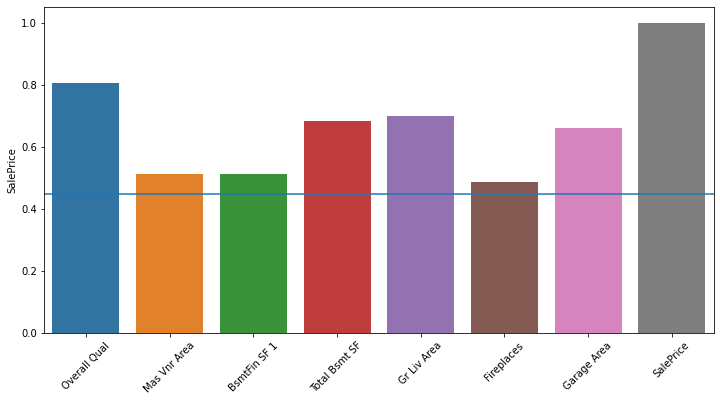

In [5]:
df_temp = transform_features(train)
df_temp_numeric = df_temp.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(12,6))
corr_mtrx = np.abs(df_temp_numeric.corr())
# sns.barplot(corr_mtrx['SalePrice'])

x = corr_mtrx['SalePrice'].index
y = corr_mtrx['SalePrice']
ax = sns.barplot(x,y)
ax.set_xticklabels(labels=x,rotation=45)
plt.axhline(y=.45)
plt.show()

Drop columns that have a weaker correlation that 0.45

In [7]:
corr_mtrx[corr_mtrx['SalePrice'] < 0.45].index

Index([], dtype='object')

Now let's figure out the threshold to drop columns that have a strong correlation with each other.

Dropped following features as they are not meaningful predictive features ['Order', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
Dropped following features as they are not meaningful predictive features ['Year Remod/Add', 'Year Built']
Dropped following features as they have a weak correlation with SalePrice Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Cond',
       'BsmtFin SF 2', 'Bsmt Unf SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'years_until_remod'],
      dtype='object')


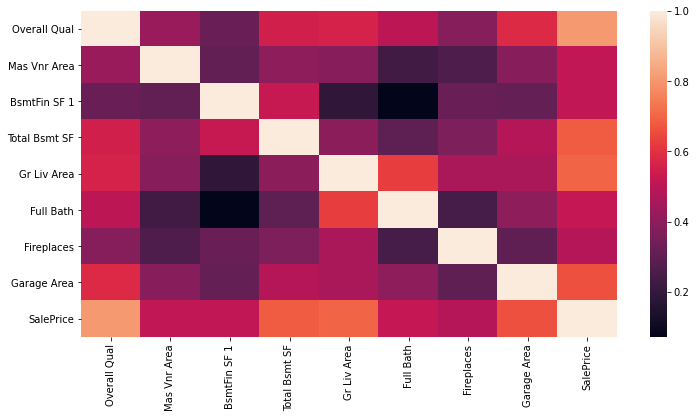

In [9]:
df_temp = transform_features(train,.05,.45)
df_temp_numeric = df_temp.select_dtypes(include=['int64','float64'])

strong_ftrs_to_drop = ['Garage Cars','1st Flr SF','TotRms AbvGrd']
df_temp_numeric.drop(columns=strong_ftrs_to_drop,inplace=True)
# Calculate the correlation matrix
corr_mtrx = np.abs(df_temp_numeric.corr())
plt.figure(figsize=(12,6))
sns.heatmap(corr_mtrx)
plt.show()


Let's now focus on non-numeric columns

In [52]:
df_temp = transform_features(train)
categoric_ftrs = df_temp.select_dtypes('object').columns
for col in categoric_ftrs:
  df_dummy = pd.get_dummies(df_temp[col])
  df_temp.drop(columns=[col],inplace=True)
  df_temp = pd.concat([df_temp,df_dummy],axis = 1).copy()
corr_mtrx = np.abs(df_temp.corr())
weak_ftrs_to_drop = corr_mtrx[corr_mtrx['SalePrice'] < .45].index
print('Dropped following features as they have a weak correlation with SalePrice',weak_ftrs_to_drop)
df_temp.drop(columns=weak_ftrs_to_drop,inplace=True)

Dropped following features as they are not meaningful predictive features ['Order', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
Dropped following features as they are not meaningful predictive features ['Year Remod/Add', 'Year Built']
Dropped following features as they have a weak correlation with SalePrice Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Cond',
       'BsmtFin SF 2', 'Bsmt Unf SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'years_until_remod'],
      dtype='object')
Dropped following features as they have a weak correlation with SalePrice Index(['C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RM', 'IR1', 'IR2', 'IR3',
       'Reg',
       ...
       'RFn', 'COD', 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New', 'Oth',
       'WD '],
      dtype='object', lengt

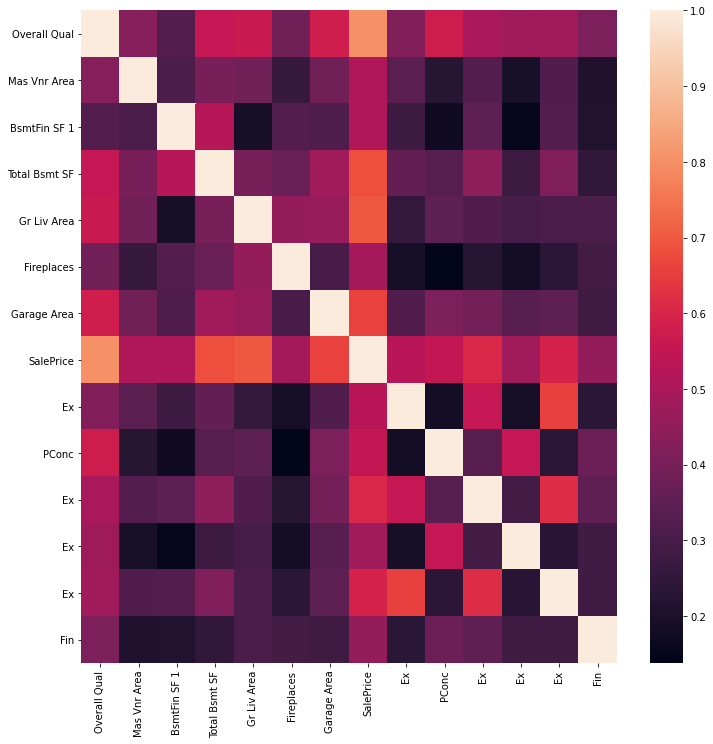

In [53]:
plt.figure(figsize=(12,12))
sns.heatmap(df_temp.corr())
plt.show()

Dropped following features as they are not meaningful predictive features ['Order', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
Dropped following features as they are not meaningful predictive features ['Year Remod/Add', 'Year Built']
Dropped following features as they have a weak correlation with SalePrice Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Cond',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'years_until_remod'],
      dtype='object')
********************************************************************************************************************
Features used in the final model Index(['Overall Qual', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area',
       'Fireplaces', 'Garage Area', 'SalePrice', 'AsbS

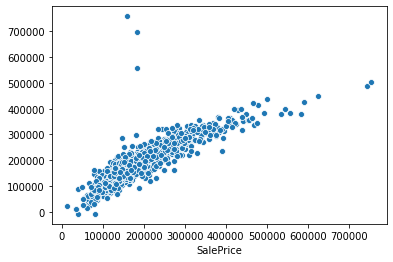

39991.067765700616

In [90]:
train_and_test(data)

In [107]:


folds = []
k = 1
for i in range(k):
  folds.append( [int((data.shape[0]/k)*i) , int((data.shape[0]/k)*(i+1))]  )


folds

[[0, 2930]]

In [18]:
train_and_test(data,k=0)

Dropped following features as they are not meaningful predictive features ['Order', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
Dropped following features as they are not meaningful predictive features ['Year Remod/Add', 'Year Built']
Dropped following features as they have a weak correlation with SalePrice Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Cond',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'years_until_remod'],
      dtype='object')
********************************************************************************************************************
Features used in the final model Index(['Overall Qual', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area',
       'Fireplaces', 'Garage Area', 'SalePrice', 'AsbS

39991.067765700616

In [42]:
train_and_test(data,k=1)

Dropped following features as they are not meaningful predictive features ['Order', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
Dropped following features as they are not meaningful predictive features ['Year Remod/Add', 'Year Built']
Dropped following features as they have a weak correlation with SalePrice Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Cond',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'years_until_remod'],
      dtype='object')
********************************************************************************************************************
Features used in the final model Index(['Overall Qual', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area',
       'Fireplaces', 'Garage Area', 'SalePrice', 'AsbS

36289.2796824106

In [46]:
train_and_test(data,k=8)

Dropped following features as they are not meaningful predictive features ['Order', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
Dropped following features as they are not meaningful predictive features ['Year Remod/Add', 'Year Built']
Dropped following features as they have a weak correlation with SalePrice Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Cond',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'years_until_remod'],
      dtype='object')
********************************************************************************************************************
Features used in the final model Index(['Overall Qual', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area',
       'Fireplaces', 'Garage Area', 'SalePrice', 'AsbS

39514.48800988018

### Execute final model

In [52]:
train_and_test(data,k=10)

Dropped following features as they are not meaningful predictive features ['Order', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
Dropped following features as they are not meaningful predictive features ['Year Remod/Add', 'Year Built']
Dropped following features as they have a weak correlation with SalePrice Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Cond',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'years_until_remod'],
      dtype='object')
********************************************************************************************************************
Features used in the final model Index(['Overall Qual', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area',
       'Fireplaces', 'Garage Area', 'SalePrice', 'AsbS

37862.10800774566